# Part 2: Forecasting prices and rents

### Work to do

The purpose of this segment is to create underwriting model in a form familiar to a real estate analyst that helps them understand the expected
returns for properties in this area.

1. Collect a small number of causal datasets that we expect to explain property price and rental income growth. These should include:
    
    For prices & rents:
    - UK National GDP
    - UK National CPI
    - UK Household income growth
    - Local population growth for the postcode (or as close to local data as you can find)


    Costs:

    - UK CPI / London CPI

Use the forecasting library developed by Vitalii (cc'd here) to construct a simple causal forecasting model of the prices, rents and costs. You can work with him
to get access to the underlying model object that gets created so you can perform feature salience analysis etc.

2. For each property size, create a projection of the rent growth and price increase over the next 10 years
3. Create a simple financial model of the investment in the property over the coming 10 years. In Real Estate team, the analysts use excel. Therefore
we will use excelwings or pyexcel to update this initial excel model with the input assumptions that you generate above. Stephen (cc'd) will be able to help
prepare a very simple excel model and answer any modelling questions you have.
4. Use charts to present the results of this analysis and the properties with the highest expected return

1) Have all the data except for LONDON CPI, which I have the national.  For the population growth I have only until 2011. Use data for Brent, whhich contains Killburn (Nw6)

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import json
import requests

from functools import reduce


-----------

## DATA LOADING

- [X] GDP (https://countryeconomy.com/gdp/uk) # has not yet been calculated for 2019
- [X] CPI (https://www.inflation.eu/inflation-rates/great-britain/historic-inflation/cpi-inflation-great-britain.aspx)
- [X] House Hold income (https://www.ons.gov.uk/peoplepopulationandcommunity/personalandhouseholdfinances/incomeandwealth/bulletins/householddisposableincomeandinequality/financialyearending2019provisional)
- [X] Population grotwh (https://data.london.gov.uk/dataset/historical-census-tables, https://data.brent.gov.uk/dataset/population-change-in-brent---key-facts population change)

### GDP

We have GDP data from 1971 until 2018

In [2]:
gdp = pd.read_csv('./part2_data/GDP.csv').rename(columns={'Year':'year'})
gdp['GDP'] = gdp['GDP'].str.strip('M.$').str.replace(',', '').astype(int)
gdp['Growth'] = gdp['Growth'].str.replace('%','').astype(float)

In [3]:
print(gdp.head())
print('\t\t\t',gdp.shape)

   year      GDP  Growth
0  2018  2828833     1.4
1  2017  2640067     1.9
2  2016  2669107     1.9
3  2015  2897060     2.4
4  2014  3036310     2.6
			 (48, 3)


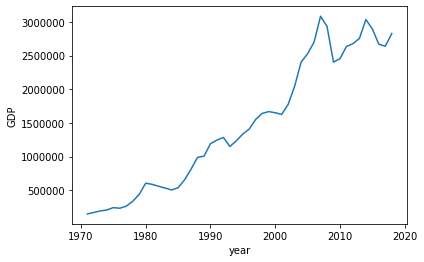

In [4]:
sns.lineplot(x=gdp['year'],y=gdp['GDP'])

### CPI

In [5]:
cpi = pd.read_csv('./part2_data/CPI.csv')
cpi['year'] = cpi['year'].str.split(' ').str[-1].astype(int)
cpi['CPI'] = cpi['CPI'].str.replace('%','').str.strip().astype(float)

In [6]:
print(cpi.head())
print('\t\t\t',cpi.shape)

   year   CPI
0  2019  1.81
1  2018  2.29
2  2017  2.56
3  2016  1.01
4  2015  0.37
			 (64, 2)


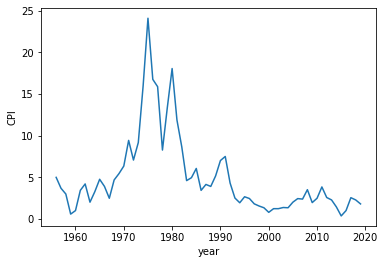

In [7]:
sns.lineplot(x=cpi['year'],y=cpi['CPI'])

###  HouseHold Income

In [8]:
hhi = pd.read_csv('./part2_data/HHI.csv', names = ['year', 'median', 'mean'], skiprows=1)
hhi = hhi.sort_values(by='year', ascending=False)

In [9]:
print(hhi.head())
print('\t\t\t',hhi.shape)

    year  median   mean
41  2018   220.1  237.2
40  2017   217.0  234.4
39  2016   217.1  230.1
38  2015   211.6  224.9
37  2014   208.3  222.2
			 (42, 3)


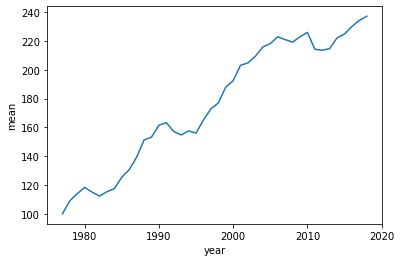

In [10]:
sns.lineplot(x=hhi['year'],y=hhi['mean'])

### Population Growth

In [11]:
ppg = pd.read_csv('./part2_data/PPG.csv', index_col=0)

ppg = pd.Series(ppg.loc['Brent'])

ppg.index = pd.to_datetime(ppg.index)

In [12]:
# AS we have the data every 10 years we can interpolate the points
ppg = ppg.resample('Y').first().interpolate(memoryviewthod='linear')

In [13]:
ppg = pd.DataFrame(ppg).reset_index().rename(columns={'index':'year', 'Brent':'PPG'})
ppg['year'] = ppg['year'].dt.year

In [14]:
print(ppg.head())
print('\t\t\t',ppg.shape)

   year     PPG
0  1801  2000.0
1  1802  2000.0
2  1803  2000.0
3  1804  2000.0
4  1805  2000.0
			 (219, 2)


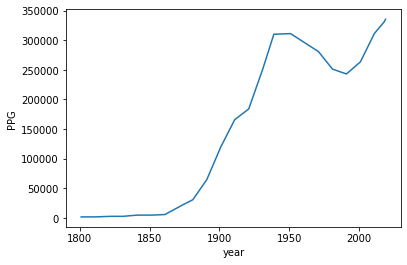

In [15]:
sns.lineplot(data=ppg, x='year', y='PPG')

-------------------

### Data merging

In [16]:
dfs_to_merge = [gdp,cpi,hhi,ppg]

In [17]:
fulldf = reduce(lambda left, right: pd.merge(left, right, on='year', how='inner'), dfs_to_merge)

In [18]:
fulldf.head()
print(fulldf.head())
print('\t\t\t',fulldf.shape)

   year      GDP  Growth   CPI  median   mean            PPG
0  2018  2828833     1.4  2.29   220.1  237.2  330800.000000
1  2017  2640067     1.9  2.56   217.0  234.4  328002.142857
2  2016  2669107     1.9  1.01   217.1  230.1  325204.285714
3  2015  2897060     2.4  0.37   211.6  224.9  322406.428571
4  2014  3036310     2.6  1.45   208.3  222.2  319608.571429
			 (42, 7)


-----------

## Building the predictive models and the forecasting

First we need to extend the explicative variables and so we will do a forecast 10 years into the future for each of them.

To check the code please look into **utilities.py**. It contains the wrappers to easily make the predictions.

In [19]:
import utilities

### Forecasting independent variables

In [20]:
predictions = fulldf.set_index('year').apply(utilities.forecast, freq='A', fh=10, \
                                             endpoint='https://deciml-forecast.com/apiworkers/ts_panel-all')\
                                      .reset_index()
predictions['year'] = predictions['year'].str[0:4].astype(int)

Finished forecasting:  GDP
Finished forecasting:  GDP
Finished forecasting:  Growth
Finished forecasting:  CPI
Finished forecasting:  median
Finished forecasting:  mean
Finished forecasting:  PPG


In [21]:
fulldf = pd.concat([fulldf, predictions]).sort_values(by='year')

In [22]:
melted_df = fulldf.melt(id_vars=['year'])

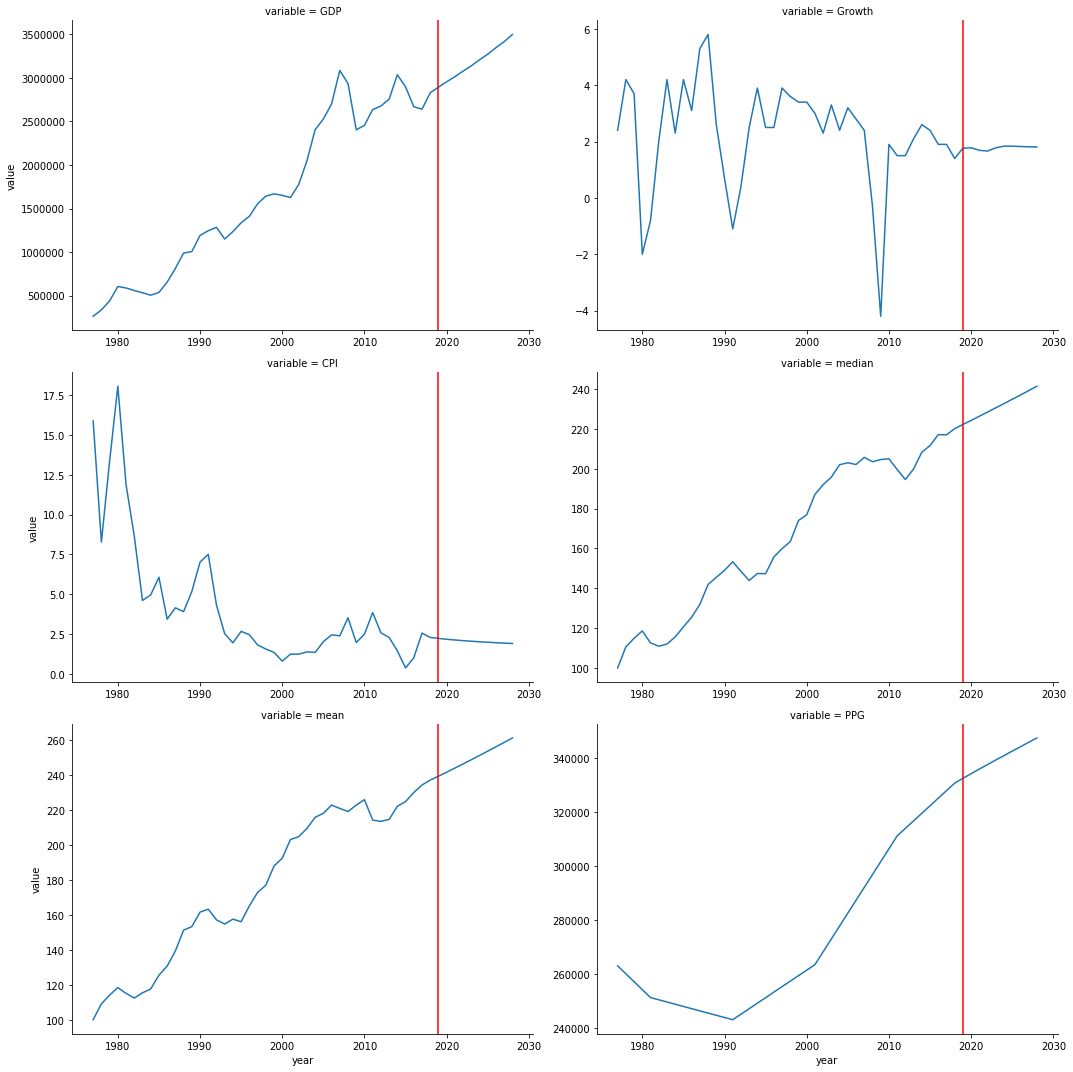

In [23]:
g = sns.FacetGrid(melted_df, col="variable", sharey=False, sharex=False, \
                  aspect=1.5, col_wrap=2, height=5)
g.map(plt.plot, 'year', 'value')

for ax in g.axes:
    ax.axvline(2019, c='red')

plt.show()

### Loading rents and prices

In [24]:
sales = pd.read_csv('nw6_data_price_fut_years_prediction.csv', index_col=0)
sales.loc[sales['beds']>=4,'beds'] = 4

In [26]:
rents = pd.read_csv('nw6_data_rent_prev_years_prediction.csv', index_col=0).rename(columns={'price': 'rent'})
rents_agg = rents.groupby(['beds', 'year'])['rent'].mean().reset_index()

In [30]:
full_data =  sales.merge(rents_agg, on=['beds', 'year'])

In [31]:
full_data

,address,attributes,postcode,beds,real_price,date,real_year,year,price,rent
0,"Flat 4, Elstow Grange 40-42, Brondesbury Park","Flat, Freehold, 3 Beds, 1 Bath, 1 Recep",NW6-7DW,3,140000,1998-11-01,1998,2012,5.848045e+05,2773.453938
1,"1, Broadhurst Mansions, 97 Broadhurst Gardens","Flat, Share of freehold, 3 Beds, 2 Baths, 1 Recep",NW6-3QP,3,197500,1998-06-01,1998,2012,8.249921e+05,2773.453938
2,"Ground And First Floor Flat, 24 Greencroft Gar...","Maisonette, Share of freehold, 3 Beds, 2 Baths...",NW6-3LS,3,265000,1998-02-01,1998,2012,1.106951e+06,2773.453938
3,36 West End Lane,"Flat, Leasehold, 3 Beds, 1 Bath, 1 Recep",NW6-4PA,3,139999,1998-08-01,1998,2012,5.848003e+05,2773.453938
4,44 Donaldson Road,"Flat, Share of freehold, 3 Beds, 3 Baths, 2 Re...",NW6-6NG,3,110000,1998-04-01,1998,2012,4.594893e+05,2773.453938
5,"Flat 3, Cumberland Mansions, West End Lane","Flat, Leasehold, 3 Beds, 2 Baths, 1 Recep",NW6-1LL,3,249000,1998-09-01,1998,2012,1.040117e+06,2773.453938
6,"Flat 30, Farjeon House, Hilgrove Road","Flat, Leasehold, 3 Beds, 2 Baths, 1 Recep",NW6-4TL,3,93500,1998-11-01,1998,2012,3.905659e+05,2773.453938
7,"Flat 5, 76 Canfield Gardens","Flat, Share of freehold, 3 Beds, 3 Baths, 1 Recep",NW6-3ED,3,340000,1998-07-01,1998,2012,1.420240e+06,2773.453938
8,30 Malvern Mews,"Mews house, Freehold, 3 Beds, 2 Baths, 1 Recep",NW6-5PT,3,210000,1998-12-01,1998,2012,8.772068e+05,2773.453938
9,30 Malvern Mews,"Mews house, Freehold, 3 Beds, 2 Baths, 1 Recep",NW6-5PT,3,180000,1998-05-01,1998,2012,7.518915e+05,2773.453938


In [32]:
rents

,real_price,beds,baths,reception,href,type,date,direction,year,rent
0,1993,2,2.0,1.0,/to-rent/details/53722191,2 bed flat to rent,14th Dec 2019,"Fairfax Place, Swiss Cottage NW6",2012,1742.156897
1,2100,2,1.0,1.0,/to-rent/details/53716641,2 bed flat to rent,13th Dec 2019,"West End Lane, London NW6",2012,1835.689655
2,1993,2,2.0,1.0,/to-rent/details/53714561,2 bed flat to rent,13th Dec 2019,"Fairfax Place, Swiss Cottage NW6",2012,1742.156897
3,2167,2,1.0,1.0,/to-rent/details/48955693,2 bed flat to rent,12th Dec 2019,"Priory Road, West Hampstead, London NW6",2012,1894.256897
4,2249,2,1.0,1.0,/to-rent/details/53709646,2 bed flat to rent,12th Dec 2019,"Sumatra Road, West Hampstead NW6",2012,1965.936207
5,1993,2,2.0,1.0,/to-rent/details/49193647,2 bed flat to rent,12th Dec 2019,"Christchurch Avenue, Brondesbury NW6",2012,1742.156897
6,2383,2,2.0,1.0,/to-rent/details/53706193,2 bed flat to rent,12th Dec 2019,"Hillfield Road, West Hampstead NW6",2012,2083.070690
7,2383,2,2.0,1.0,/to-rent/details/53699123,2 bed flat to rent,11th Dec 2019,"Hillfield Road, London NW6",2012,2083.070690
8,3200,2,1.0,1.0,/to-rent/details/53695389,2 bed flat to rent,11th Dec 2019,"Brondesbury Villas, London NW6",2012,2797.241379
9,1907,2,1.0,1.0,/to-rent/details/53678407,2 bed flat to rent,10th Dec 2019,"Charteris Road, London NW6",2012,1666.981034


In [38]:
rents['direction'].str.split(',').str[1].unique()

array([' Swiss Cottage NW6', ' London NW6', ' West Hampstead',
       ' West Hampstead NW6', ' Brondesbury NW6', ' Queens Park NW6',
       ' South Hampstead', ' Kilburn Park Road', ' Queens Park',
       ' South Hampstead NW6', ' Brondesbury', ' North Maida Vale NW6',
       ' Brondesbury Park', ' West Hamptead', ' London',
       ' Christchurch Avenue', ' Kilburn Park NW6', ' Kilburn NW6',
       ' Swiss Cottage', ' Fairfax Place', ' 7 Kilburn Priory',
       ' Kilburn', ' Brondesbury Park NW6', ' Maida Vale',
       ' 65 Maygrove Road', ' Heritage Lane', " Queen's Park",
       ' Kingsgate Place', ' Heritage Lane NW6', ' Mill Lane',
       ' 35 Salusbury Road NW6', ' West Hampstead/Kilburn',
       ' Willesden Lane', ' Kensal Rise NW6', ' Compayne Gardens',
       ' 52 Lymington Road', ' 180 Kilburn Park Road',
       ' Fortune Green Road', ' Acol Road', ' Lymington Road',
       ' Greencroft Gardens', ' Mapesbury Estate', ' Belsize Road',
       ' Kimberley Road', ' West End Lane',

In [ ]:
https://postcodebyaddress.co.uk/nw6-2

NW6 1
Achilles Road
Agamemnon Road
Ajax Road
Aldred Road
Alvanley Gardens
Berridge Mews
Beswick Mews
Blackburn Road
Broomsleigh Street
Burrard Road
Cannon Hill
Cathedral Walk
Crediton Hill
Crown Close
Dennington Park Road
Dornfell Street
Doulton Mews
Fawley Road
Fortune Green Road
Glastonbury Street
Glenbrook Road
Gondar Gardens
Hillfield Road
Holmdale Road
Honeybourne Road
Ingham Road
Inglewood Road
Kingdon Road
Lymington Road
Lyncroft Gardens
Mill Lane
Minton Mews
Narcissus Road
Orestes Mews
Pandora Road
Parsifal Road
Ravenshaw Street
Rose Joan Mews
Sandwell Crescent
Solent Road
Sumatra Road
Ulysses Road
Wedgwood Walk
Weech Road
West Cottages
West End Lane
Worcester Mews